In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import seaborn as sns
import numpy as np
torch.manual_seed(42)

In [2]:
dataset_dir = '/kaggle/input/cleaned-brain-storke/clean_dataset'
testset_dir = '/kaggle/input/cleaned-testset/testset'

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.19176629185676575, 0.19176629185676575, 0.19176629185676575],
                         std=[0.3061337471008301, 0.3061337471008301, 0.3061337471008301]) 
])

# Load dataset using ImageFolder
dataset = ImageFolder(root=dataset_dir, transform=transform)
testset = ImageFolder(root=testset_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [3]:
#dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

#sum_pixels = 0
#sum_squared_pixels = 0
#num_pixels = 0

#for images, _ in dataloader:
#    sum_pixels += torch.mean(images, dim=[0, 2, 3])
#    sum_squared_pixels += torch.mean(images**2, dim=[0, 2, 3])
#    num_pixels += 1

#mean = sum_pixels / num_pixels
#std = (sum_squared_pixels / num_pixels - mean**2).sqrt()
#print(f"Mean: {mean.tolist()}")
#print(f"Std: {std.tolist()}")

In [4]:
print(dataset.class_to_idx)
print(testset.class_to_idx)

{'inme Yok_kronik surec_diger Veri Set_PNG': 0, 'iskemi ve Kanama Veri Seti': 1}
{'0_zero': 0, '1_one': 1}


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

In [6]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=1)
model.classifier = nn.Sequential(  
    nn.Linear(model.config.hidden_size, 1)  
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs!


DataParallel(
  (module): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
      

In [7]:
for param in model.module.vit.parameters():
    param.requires_grad = False  

for param in model.module.classifier.parameters():
    param.requires_grad = True

In [8]:
optimizer = optim.AdamW([
    {'params': model.module.vit.parameters(), 'lr': 1e-5},
    {'params': model.module.classifier.parameters(), 'lr': 1e-3}
])
criterion = nn.BCEWithLogitsLoss() 

In [9]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 100

# Training loop
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Iterate through training data
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).logits
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track running loss
        running_train_loss += loss.item()

        # Track accuracy
        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()

            # Forward pass
            outputs = model(inputs).logits
            loss = criterion(outputs.squeeze(), labels.float())

            running_val_loss += loss.item()

            # Track validation accuracy
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, ')

Epoch [1/100], Train Loss: 0.6090, Train Accuracy: 67.19%, Validation Loss: 0.5634, Validation Accuracy: 72.16%, 
Epoch [2/100], Train Loss: 0.5391, Train Accuracy: 75.23%, Validation Loss: 0.5200, Validation Accuracy: 78.68%, 
Epoch [3/100], Train Loss: 0.4995, Train Accuracy: 77.42%, Validation Loss: 0.4882, Validation Accuracy: 77.00%, 
Epoch [4/100], Train Loss: 0.4725, Train Accuracy: 79.49%, Validation Loss: 0.4655, Validation Accuracy: 80.63%, 
Epoch [5/100], Train Loss: 0.4518, Train Accuracy: 80.56%, Validation Loss: 0.4493, Validation Accuracy: 79.98%, 
Epoch [6/100], Train Loss: 0.4351, Train Accuracy: 81.40%, Validation Loss: 0.4357, Validation Accuracy: 81.19%, 
Epoch [7/100], Train Loss: 0.4239, Train Accuracy: 81.70%, Validation Loss: 0.4295, Validation Accuracy: 80.26%, 
Epoch [8/100], Train Loss: 0.4092, Train Accuracy: 82.70%, Validation Loss: 0.4155, Validation Accuracy: 82.50%, 
Epoch [9/100], Train Loss: 0.4013, Train Accuracy: 82.58%, Validation Loss: 0.4078, Vali

In [10]:
torch.save(model.state_dict(), 'Vit1e-5-batch32-model.pth') 

In [11]:
# Function to Evaluate Model on Any Dataset (Validation or Test)
def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred_prob = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            probabilities = torch.sigmoid(outputs)
            
            y_true.extend(labels.cpu().numpy())
            y_pred_prob.extend(probabilities.cpu().numpy())

    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  
    auc_score = roc_auc_score(y_true, y_pred_prob)
    f1 = f1_score(y_true, y_pred)

    print(f"\nConfusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return y_true, y_pred_prob, cm, auc_score, accuracy, precision, recall, specificity, f1


In [12]:
def draw_graph(y_true, y_pred_prob, cm, auc_score):
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="darkorange")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


 Evaluating on Validation Set:

Confusion Matrix:
[[620  43]
 [ 79 332]]
Accuracy: 0.8864
Precision: 0.8853
Recall (Sensitivity): 0.8078
Specificity: 0.9351
AUC Score: 0.9416
F1 Score: 0.8448


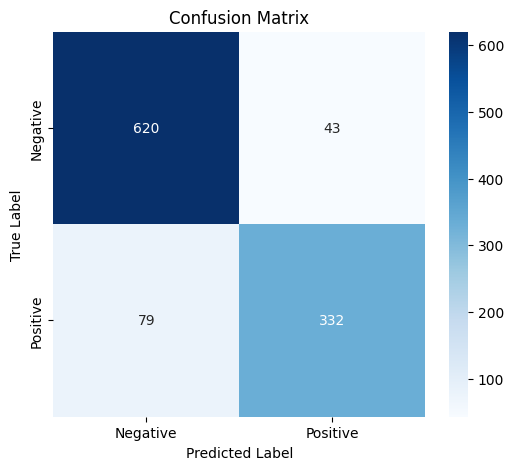

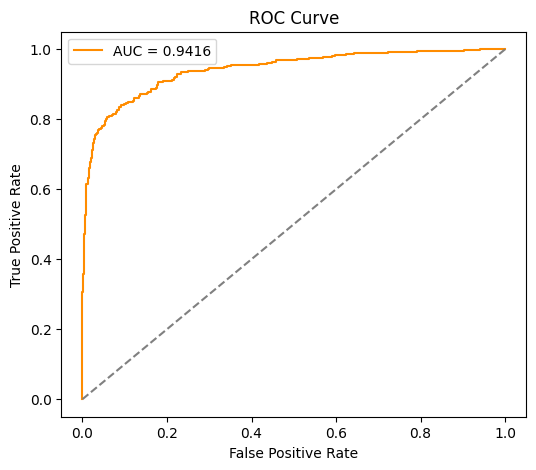


 Ealuating on Test Set:

Confusion Matrix:
[[101  18]
 [ 22  38]]
Accuracy: 0.7765
Precision: 0.6786
Recall (Sensitivity): 0.6333
Specificity: 0.8487
AUC Score: 0.8780
F1 Score: 0.6552


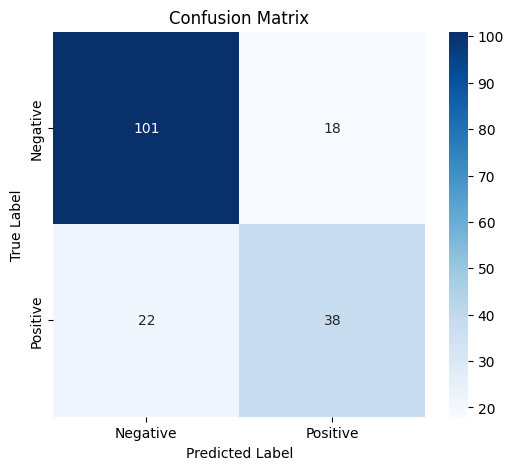

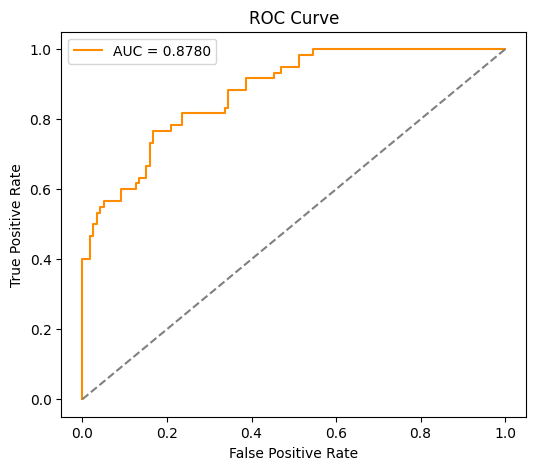

In [13]:
print("\n Evaluating on Validation Set:")
evaluation_list = evaluate_model(model, val_dataloader)
y_true, y_pred_prob, cm, auc_score = evaluation_list[:4]
draw_graph(y_true, y_pred_prob, cm, auc_score)
print("\n Ealuating on Test Set:")
test_evaluation_list = evaluate_model(model, test_dataloader)
t_y_true, t_y_pred_prob, t_cm, t_auc_score = test_evaluation_list[:4]
draw_graph(t_y_true, t_y_pred_prob, t_cm, t_auc_score)

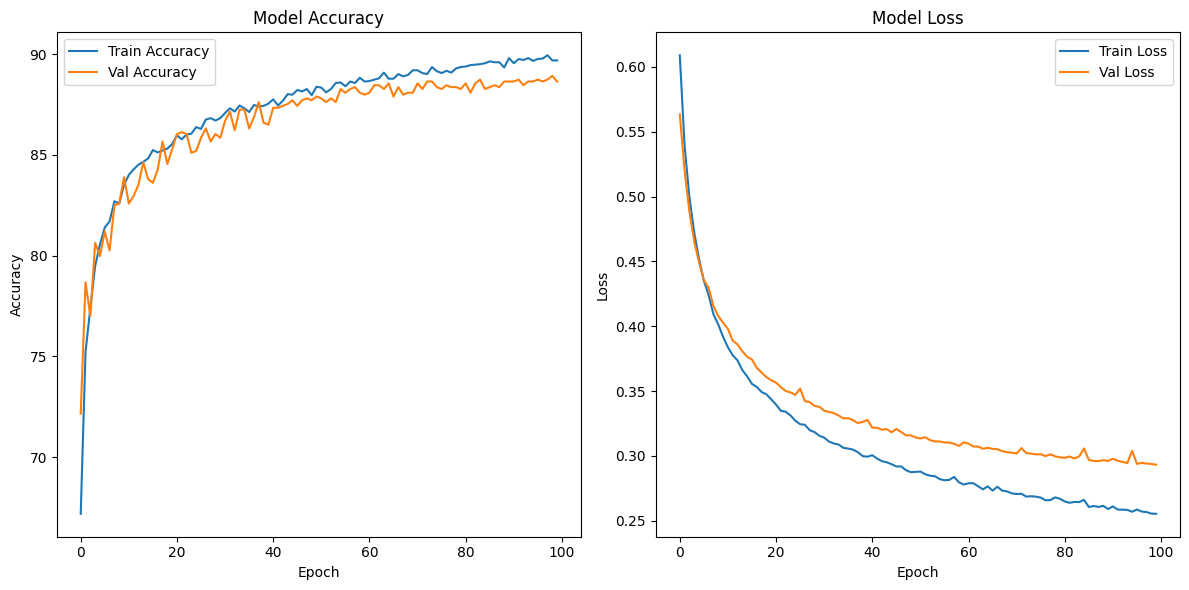

In [14]:
    # Plot Train_Val accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Train_Val loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()